# Nested Sampling Algorithm

- Jeffrey's prior for $D_0$
- Uniform Priors for $\alpha$, $f$ and $\sigma^2_{mn}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.stats as stats

In [2]:
def jeff(x,magmin, magmax):
    return magmin*exp(u*log(magmax/magmin))
def uni(x, magmin, magmax):
    return 1/(magmax, magmin)


In [220]:
@jit
def noisylikelihoodcalc(posn, DT, D, ALPHA, F, varmn):
    # time series
    n = len(posn)

    #init value
    logl = 0
    k_BT =1
    

    # Intial values of the variance mean both noisy and clean
    mob = D * (np.abs(posn[0]) ** ALPHA)
    std_dev_noise = 2 * mob * DT + 2 * varmn
    noisy_mean = posn[0] + (mob * F + k_BT * (ALPHA * D * ((np.abs(posn[0]) ** (ALPHA - 1)) * (np.sign(posn[0]))))) * DT
    
    # log likelihood at 1st step
    logl = logl - ((posn[1] - noisy_mean) ** 2) / (2 * std_dev_noise) - np.log(np.sqrt(2 * np.pi * std_dev_noise))
    
    for i in range(2,n):
        # Mobility at the step
        mob = D * np.abs(posn[i - 1]) ** ALPHA

        # clean variance at the jth step
        std_dev = 2 * mob * DT

        # clean mean position at the jth time step
        mean_dist = posn[i - 1] + (mob * F + ALPHA * D * (np.abs(posn[i - 1]) ** (ALPHA - 1)) * (np.sign(posn[i - 1]))) * DT

        # noisy mean position at the jth step
        noisy_mean = mean_dist - varmn/(std_dev_noise) * (posn[i-1] - noisy_mean)

        # noisy variance at the jth posn
        std_dev_noise = std_dev + varmn * (2 - varmn / std_dev_noise)

        # calculation of log likelihood
        logl = logl - ((posn[i] - noisy_mean) ** 2) / (2 * std_dev_noise) - 0.5 * np.log(2 * np.pi * std_dev_noise)
    
    return logl

In [4]:
@jit
def Evidence(data, theta, npoints, tol):
    logZ = 0
    walker = walkergen(npoints, theta_max, theta_min)
    for i in range(0,npoints):
        ll[i] = noisylikelihoodcalc(p_data, 1, walker[i][0], walker[i][1], walker[i][2], walker[i][3])
    
    

In [5]:
@jit
def walkergen(n, tmax, tmin):
    x = np.zeros((n,4))
    for i in range(0,n):
        for j in range(0,4):
            x[i][j] = np.random.uniform(tmin[j],tmax[j])
    return x

In [6]:
@jit 
def logsum(a, b):
    return max(a,b) + np.log(1+ np.exp(-np.abs(a-b)))

In [297]:
D_min = 10**(-4)
D_max = 10**2
# D_min = 0.
# D_max = 1.


f_min = -1.
f_max = 1.

alpha_min = -2.
alpha_max = 2.

varmn_min = 0.
varmn_max = 1.

theta_max = np.array([D_max, alpha_max, f_max, varmn_max])
theta_min = np.array([D_min, alpha_min, f_min, varmn_min])


In [298]:
npoints = 20

walkers = np.zeros((npoints,4))

walker = walkergen(npoints, theta_max, theta_min)


p_data = np.array([50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926])

ll = np.zeros(npoints)

In [22]:
for i in range(0,npoints):
    ll[i] = noisylikelihoodcalc(p_data, 1, walker[i][0], walker[i][1], walker[i][2], walker[i][3])

ll

Nsteps

tol = -4

wt = 1/(npoints + 1)

Z = np.exp(min(ll))*wt

wt = 1/(npoints + 1)

logZ = np.log(0)
logp = min(ll)+ np.log(wt)
logZ = logsum(logZ,logp)
logZrem = -np.log(npoints + 1)

step = 0

j=1

lstar = []

# for i in range(0,npoints):
    # logZrem = logsum(logZrem, )

logZrem = logZdel - logZ

while True:
    # log width contraction
    logwt = logwt + np.log(npoints/(npoints+1))

    # log likelihood calculation
    ll = [noisylikelihoodcalc(p_data, 1, walker[i][0], walker[i][1], walker[i][2], walker[i][3]) for i in range(0,npoints) for i in range(0, npoints)]

    # lowest likelihood of all the walkers
    lstar.append(min(ll))

    # log Z finding
    logZ = logsum(logZ, (lstar[-1] + logwt))
    
    # logZrem = np.log(sum(ll))*
    R = logZrem - logZ
    if R < tol:
        break
        
    p = np.where(ll == min(ll))[0]

    # randomly select a walker to copy and random walk
    newwalkernumber = np.random.randint(1,npoints+1)

    # parameters of the randomly selected walker
    thetawalker = walker[newwalkernumber]

    # walker replacement  
    # step, walker[p] = MCMCwalker(p_data, 1, theta, walker[p], lstar[-1] , Nsteps, step)

    #Zrem Calc

    # interim stop

    #Information    
tol

/tmp/ipykernel_7466/2276444276.py:14: RuntimeWarning: divide by zero encountered in log
  logZ = np.log(0)


TypeError: not enough arguments: expected 2, got 1

In [92]:
# np.log(np.exp(np.log(0)) + np.exp(2));
logsum(np.log(0),5)

/tmp/ipykernel_255041/3760685357.py:2: RuntimeWarning: divide by zero encountered in log
  logsum(np.log(0),5)


5.0

In [10]:
logsum(1,2)

2.313261687518223

In [49]:
np.random.randint(1,npoints+1)

6

# MCMC walker

Tried my hand at coding a MCMC walker using the Metropolis Hastings algo. The proposal function is a standard gaussian. The results are not ideal.

In [295]:
# @jit
def MCMCwalker(x, DT, walker, Lstar, N, step = 0):
    
    if step == 0:
        step = 1

    # assigning parameter values for the walker 
    D = walker[0]
    a = walker[1]
    f = walker[2]
    mn = walker[3]
    
    R = 0

    # intializing the walker distribution
    walker_new = np.zeros((N,4))

    # init proposal function
    # proposal for new points in parameter space
    prop = np.zeros(4)

    #rejection count to determine new steps
    rejcount = 0 

    #initial walker value is the intial walker point
    walker_new[0] = walker 

    #counter variable
    i = 1
    
    while i<N:
        
        #setting new values using the proposal function
        for j in range(0,4):
            prop[j] = walker_new[i-1][j] + np.random.normal(0,step)

        # log likelihood of the walker
        llwalker = noisylikelihoodcalc(x, DT, *prop)

        #moving around prior landscape
        if llwalker >= Lstar:
            walker_new[i] = prop
            Lstar = llwalker
        else:
            walker_new[i] = walker_new[i-1]
            rejcount += 1
        i+=1

    # Rejection Ratio
    R = rejcount/N

    #new step
    step = min(step * np.exp( 0.5 - R), 1)
    
    return step, walker_new, walker_new[-1]         

In [249]:
N=500000
a = walkergen(1,theta_max,theta_min)[0]
lla = noisylikelihoodcalc(p_data, 1, *a)
a,lla

(array([11.80675257, -1.38165811, -0.67081515,  3.57768302]),
 -1001.0126734678046)

In [300]:
a = walkergen(1,theta_max,theta_min)[0]
lla = noisylikelihoodcalc(p_data, 1, *a)
print("init_Walker = " + str(a))
print("init likelihood = " +str(lla))
t = MCMCwalker(p_data, 1, a, lla, N, step)
step = t[0]
fp = t[2]
llf = noisylikelihoodcalc(p_data, 1, fp[0], fp[1], fp[2], fp[3])
fp
t[1]
llf,fp

init_Walker = [41.39802076 -1.18364817 -0.34440376  0.79810616]
init likelihood = -1702.3795245228876


(-179.16931994050168,
 array([ 0.14305711,  1.05263164, -0.27306209,  0.02627767]))

In [259]:
t[1]

array([[ 0.25323123,  0.54183061, -0.6625004 ,  0.55793117],
       [ 0.25051757,  0.56402904, -0.66226335,  0.53377599],
       [ 0.27442598,  0.57158601, -0.66144929,  0.5817193 ],
       ...,
       [ 0.14334919,  1.05323543, -0.26928795,  0.0260316 ],
       [ 0.14334919,  1.05323543, -0.26928795,  0.0260316 ],
       [ 0.14334919,  1.05323543, -0.26928795,  0.0260316 ]])

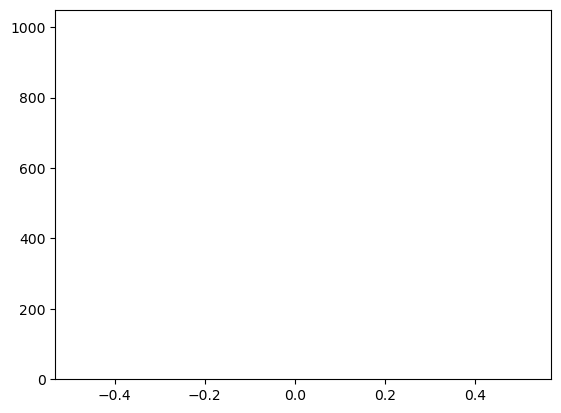

In [266]:
plt.hist(t[:][0],bins = 1000, density = True);

In [231]:
llt = noisylikelihoodcalc(p_data, 1, 0.2, 1,-0.3,0)
llt

-180.397045194095

In [283]:
lol = np.array(t[1])
lol[:,0]

array([0.25323123, 0.25051757, 0.27442598, ..., 0.14334919, 0.14334919,
       0.14334919])

In [285]:
lol[:,0].mean(), lol[:,1].mean(), lol[:,2].mean(), lol[:,3].mean()

(0.14316347616580058,
 1.053461774617821,
 -0.27085853311657937,
 0.02611041935767762)

(0.12917107878070405, 0.15)

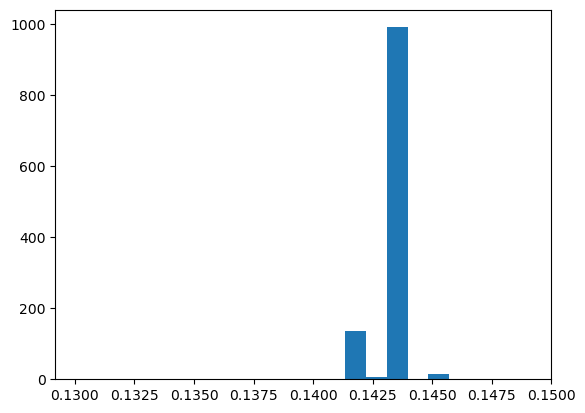

In [292]:
plt.hist(lol[:,0], bins =200,density = True);
plt.xlim(right = 0.15)

In [80]:
trace = MCMCwalker(p_data, 1, [0.3,1.,-0.3,0.],theta_max,theta_min,100000, step)
step = trace[0]
post = trace[1]

TypeError: MCMCwalker() takes from 5 to 6 positional arguments but 7 were given

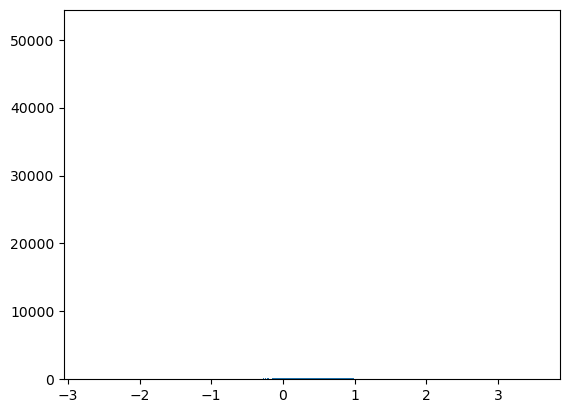

In [19]:
plt.hist(post, bins = 1000);
# plt.xlim(

In [21]:
post.mean()

0.1815196290978814

In [63]:
max(post)

132.500899310604